In [26]:
#Libraries
import pathlib
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

In [ ]:
eng_file = '/content/drive/MyDrive/en-ta/train.en'
tamil_file = '/content/drive/MyDrive/en-ta/train.ta'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(eng_file, 'r') as file:
    english_sentences = file.readlines()
with open(tamil_file, 'r') as file:
    tamil_sentences = file.readlines()


english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
tamil_sentences = [sentence.rstrip('\n') for sentence in tamil_sentences]

In [ ]:
# filter out sentences which contains letters other than whats listed below
tamil_vocabulary = [ ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ',
                      "ஃ", "அ", "ஆ", "இ", "ஈ", "உ", "ஊ", "எ", "ஏ", "ஐ", "ஒ", "ஓ", "ஔ",
                      "க", "ங", "ச", "ஜ", "ஞ", "ட", "ண",
                      "த", "ந", "ன", "ப", "ம", "ய", "ர",
                      "ற", "ல", "ள", "ழ", "வ", "ஶ", "ஷ", "ஸ", "ஹ",
                      "ா", "ி", "ீ", "ு", "ூ", "ெ", "ே", "ை", "ொ", "ோ", "ௌ", "்", "ௗ",
                      "௦", "௧", "௨", "௫", "௬", "௲", "௳"
                      ]

english_vocabulary = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~']

In [ ]:
def is_valid_tokens(sentence , vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

valid_sentence_indicies = []
for index in range(len(english_sentences[:400000])):
    tamil_sentence, english_sentence = tamil_sentences[index], english_sentences[index]
    if is_valid_tokens(tamil_sentence, tamil_vocabulary) \
      and is_valid_tokens(english_sentence , english_vocabulary):
        valid_sentence_indicies.append(index)

In [ ]:
TOTAL_SENTENCES = 200000 # lets take 200000 valid sentences to train the model
x = [english_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]
y = [tamil_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]

In [ ]:
import pandas as pd
dataset =  pd.DataFrame({"English":x , "Tamil":y })
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   English  200000 non-null  object
 1   Tamil    200000 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [ ]:
dataset.sample(5)

,English,Tamil
83292,"for that, he thanked people of the area and pa...","இவருக்கு காங்கிரஸ் கட்சியின் நிா்வாகிகளும், அந..."
160422,she said that these initiatives have up-graded...,வீட்டு வசதி நிதித் துறையை இந்திய ரிசர்வ் வங்கி...
159073,"hence, action is being taken to set up an agro...",எனவே கிருஷ்ணகிரி மண்டல ஊரக வளர்ச்சி மற்றும் ஊர...
86022,recent statistics in the us reveal that in 200...,"அமெரிக்காவில் சமீபத்திய புள்ளிவிவரங்கள், 2005ம..."
97840,even paul had to endure a continuing conflict ...,"இது, தேவபக்தியை வெளிக்காட்டுவதில் நல்ல ஆன்மீக ..."


In [ ]:
dataset.to_csv('/content/drive/MyDrive/NMT-Project/data.csv' , index = False )

In [27]:
dataset = pd.read_csv('/content/general_en_ta 87k (2).csv')
dataset.head()

,Unnamed: 0,0,1
0,0,Go.,போ.
1,1,Go.,போ.
2,2,Go.,போ.
3,3,Go.,போ.
4,4,Hi.,வணக்கம்.


In [28]:
text_pairs = []

for i in range(dataset.shape[0]) :
    eng = str(dataset["0"][i])
    tam = "[start] " + str(dataset["1"][i]) + " [end]"
    text_pairs.append((eng,tam))

In [29]:
len(text_pairs)


87528

In [30]:
train_sample_size = len(text_pairs) - int(0.1*len(text_pairs))
train_pairs = text_pairs[:train_sample_size]
test_pairs = text_pairs[train_sample_size:]

In [31]:
print("Total pairs :", len(text_pairs))
print("Train pairs :", len(train_pairs))
print("Test pairs :", len(test_pairs))

Total pairs : 87528
Train pairs : 78776
Test pairs : 8752


In [32]:
strip_chars = string.punctuation + "|"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace('""', "")

vocab_size = 35000
sequence_length = 30
batch_size = 64

In [33]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

---

In [34]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)

tam_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [35]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_tam_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
tam_vectorization.adapt(train_tam_texts)

In [36]:
import json

# Get the vocabulary
eng_vocab = eng_vectorization.get_vocabulary()
tam_vocab = tam_vectorization.get_vocabulary()


# Save the vocabulary
with open('/content/eng_vocab.json', 'w') as f:
    json.dump(eng_vocab, f)
with open('/content/tam_vocab.json', 'w') as f:
    json.dump(tam_vocab, f)

In [37]:
import json


vocab_size = 35000
sequence_length = 30
batch_size = 64


# Load the vocabulary
with open('/content/eng_vocab.json', 'r') as f:
    eng_vocab = json.load(f)
with open('/content/tam_vocab.json', 'r') as f:
    tam_vocab = json.load(f)

# Create a TextVectorization layer with the loaded vocabulary
eng_vectorization = TextVectorization(vocabulary=eng_vocab,output_mode="int", output_sequence_length=sequence_length)
tam_vectorization = TextVectorization(vocabulary=tam_vocab,output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization)

In [38]:
def format_dataset(eng, tam):
    eng = eng_vectorization(eng)
    tam = tam_vectorization(tam)
    return ({"encoder_inputs": eng, "decoder_inputs": tam[:, :-1],}, tam[:, 1:])

In [39]:
def make_dataset(pairs):
    eng_texts, tam_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    tam_texts = list(tam_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, tam_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

In [40]:
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [41]:
for inputs, targets in train_ds.take(2):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 30)
inputs["decoder_inputs"].shape: (64, 30)
targets.shape: (64, 30)
inputs["encoder_inputs"].shape: (64, 30)
inputs["decoder_inputs"].shape: (64, 30)
targets.shape: (64, 30)


In [42]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [43]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
         return keras.ops.not_equal(inputs, 0)

In [44]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)

        # Always define padding_mask
        padding_mask = causal_mask  # default: just causal
        if mask is not None:
            base_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")   # [batch, 1, seq]
            # broadcast causal_mask [1, seq, seq] with base_mask
            padding_mask = tf.minimum(base_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2  = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [45]:
embed_dim = 256
latent_dim = 512
num_heads = 4


encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)
i

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:1474: UserWarning: Layer 'transformer_encoder' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''cannot access local variable 'padding_mask' where it is not associated with a value''
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented

87527

In [46]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [47]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_3' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [48]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  8,967,680 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 256) │  1,315,840 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, None,      │ 20,330,936 │ decoder_inputs[0… │
│ (Functional)        │ 35000)            │            │ transformer_enco… │
│                     │                   │            │ not_equal[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,614,456 (116.78 MB)

 Trainable params: 30,614,456 (116.78 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}

In [50]:

learning_rate = CustomSchedule(latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

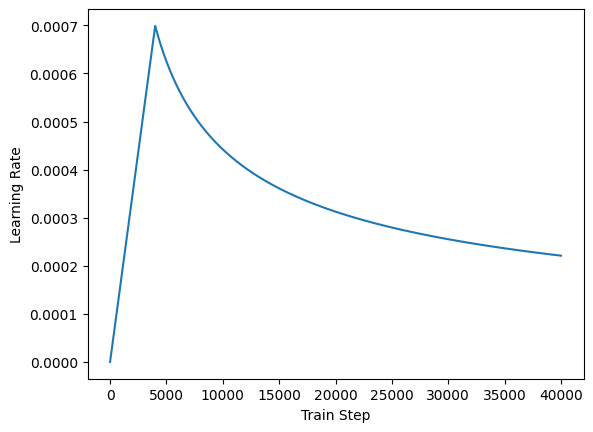

In [51]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [52]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import os

drive_root = "/content/drive/MyDrive/transformer_training-ver2"

# Create directories if not exist
os.makedirs(drive_root, exist_ok=True)

checkpoint_filepath = os.path.join(drive_root, "checkpoint.keras")
csv_log_filepath = os.path.join(drive_root, "training_log.csv")
backup_dir = os.path.join(drive_root, "backup")
os.makedirs(backup_dir, exist_ok=True)


In [54]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

csv_logger = callbacks.CSVLogger(csv_log_filepath, append=True)

backup_callback = callbacks.BackupAndRestore(
    backup_dir=backup_dir,
    delete_checkpoint=False
)

all_callbacks = [early_stopping, model_checkpoint_callback, csv_logger, backup_callback]


In [64]:

epochs = 25
transformer.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [65]:
# tf.config.run_functions_eagerly(True)

In [66]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds ,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ] )

Epoch 25/25
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 148s 107ms/step - accuracy: 0.1614 - loss: 1.5818 - val_accuracy: 0.1364 - val_loss: 3.9577


In [67]:
transformer.save('/content/V1-50k-106M.keras')


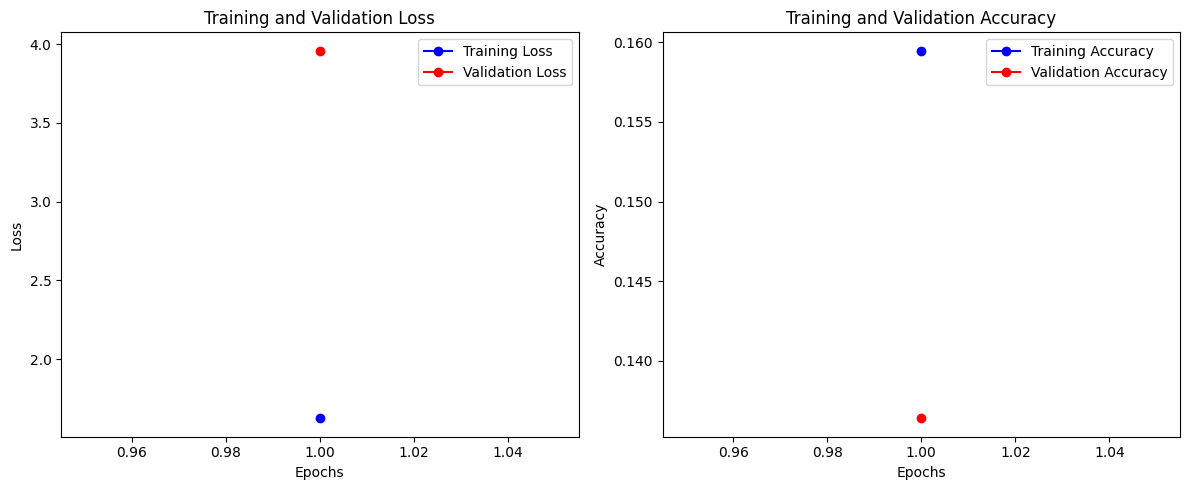

In [68]:
import os
def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    plt.show()
plot_loss_and_accuracy(history ,"/content/drive/MyDrive/NMT-Project", "V1-50k-106M_trainloss.png" )

In [69]:
tam_vocab = tam_vectorization.get_vocabulary()
tam_index_lookup = dict(zip(range(len(tam_vocab)), tam_vocab))
max_decoded_sentence_length = 20

In [70]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = tam_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = tam_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

### Testing on Random Train Samples

In [71]:
# 1
sample  = random.choice(train_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  I knew Tom was a Canadian.
Tamil
Ground Truth :  [start] டாம் ஒரு கனடியன் என்று எனக்குத் தெரியும். [end]
Machine Translation :  [start] டாம் ஒரு கனடியன் என்று எனக்குத் தெரியும் [end]


In [ ]:
# 2
sample  = random.choice(train_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  I didn't even know you knew.
Tamil
Ground Truth :  [start] உங்களுக்குத் தெரியும் என்று கூட எனக்குத் தெரியாது. [end]
Machine Translation :  [start] உன்னை யாருக்கும் தெரியாது [end]


In [ ]:
# 3
sample  = random.choice(train_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  They'll never understand.
Tamil
Ground Truth :  [start] அவர்கள் ஒருபோதும் புரிந்து கொள்ள மாட்டார்கள். [end]
Machine Translation :  [start] அவர்கள் ஒருபோதும் புரிந்து கொள்ள மாட்டார்கள் [end]


### Testing on Random Test samples

In [ ]:
# 1
sample  = random.choice(test_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  Tom doesn't even talk to Mary anymore.
Tamil
Ground Truth :  [start] டாம் மேரியுடன் பேசவே இல்லை. [end]
Machine Translation :  [start] டாம் மேரியை இனி பேச விரும்பவில்லை [end]


In [ ]:
# 2
sample  = random.choice(test_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  There's no way I'm going to do that.
Tamil
Ground Truth :  [start] நான் அதைச் செய்ய வழியில்லை. [end]
Machine Translation :  [start] நான் அதைச் செய்ய வேண்டிய வேலை செய்யவில்லை [end]


In [ ]:
# 3
sample  = random.choice(test_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  He was angry because of what she said.
Tamil
Ground Truth :  [start] அவள் சொன்னதால் அவனுக்கு கோபம் வந்தது. [end]
Machine Translation :  [start] அவள் என்ன பெண் என்று அவர் மீது கோபமாக இருந்தார் [end]


### Testing on custom input

In [ ]:
input_sentence = "My name is saliniyan"
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Machine Translation : ' , translated )

English -  My name is saliniyan
Tamil
Machine Translation :  [start] என் பெயர் வேலை [end]


In [ ]:
input_sentence = "I will buy milk later"
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Machine Translation : ' , translated )

English -  I will buy milk later
Tamil
Machine Translation :  [start] நான் பால் வாங்க முடியும் [end]


In [ ]:
input_sentence = "he is my friend."
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Machine Translation : ' , translated )

English -  he is my friend.
Tamil
Machine Translation :  [start] அவர் என் நண்பர் [end]


---

In [ ]:
input_sentence = "he went to london."
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Machine Translation : ' , translated )

English -  he went to london.
Tamil
Machine Translation :  [start] அவர் லண்டன் சென்றார் [end]


In [76]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.chrf_score import corpus_chrf

# Initialize metrics
bleu_scores = []
references = []
hypotheses = []

smooth = SmoothingFunction().method1

# English input sentences
sentences = [
    "I will buy milk later",
    "he is my friend.",
    "he went to india",
    "however, no action has so far been taken on the complaints."
]

# Corresponding Tamil ground-truth translations (replace with your dataset ground-truths!)
ground_truths = [
    "நான் பிறகு பால் வாங்குவேன்",
    "அவர் என் நண்பர்.",
    "அவர் இந்தியா சென்றார்.",
    "எனினும், புகார்களுக்கு இதுவரை எந்த நடவடிக்கையும் எடுக்கப்படவில்லை."
]

# Loop over sentences
for i in range(len(sentences)):
    input_sentence = str(sentences[i])
    translated = decode_sequence(input_sentence)  # model output
    ground_truth = ground_truths[i]

    print("Input:", input_sentence)
    print("Predicted:", translated)
    print("Reference:", ground_truth)

    # Prepare for score calculation
    references.append([ground_truth.split()])  # BLEU expects list of list
    hypotheses.append(translated.split())

    # BLEU score per sentence
    bleu = sentence_bleu([ground_truth.split()], translated.split(), smoothing_function=smooth)
    bleu_scores.append(bleu)
    print("BLEU:", bleu)
    print("-" * 40)

# Calculate overall metrics
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_chrf = corpus_chrf([ref[0] for ref in references], hypotheses)

print("\n===== Overall Scores =====")
print("Average BLEU:", avg_bleu)
print("Average chrF:", avg_chrf)


Input: I will buy milk later
Predicted: [start] நான் பிறகு பால் வாங்க முடியும் [end]
Reference: நான் பிறகு பால் வாங்குவேன்
BLEU: 0.16348126556655487
----------------------------------------
Input: he is my friend.
Predicted: [start] அவன் என் நண்பன் [end]
Reference: அவர் என் நண்பர்.
BLEU: 0.05372849659117709
----------------------------------------
Input: he went to india
Predicted: [start] அவர் மன பெற சென்றார் [end]
Reference: அவர் இந்தியா சென்றார்.
BLEU: 0.040824829046386304
----------------------------------------
Input: however, no action has so far been taken on the complaints.
Predicted: [start] எந்த பிரச்சனையும் இல்லை என்பது வேகமாக உன்னைப் கவனிக்க வேண்டாம் [end]
Reference: எனினும், புகார்களுக்கு இதுவரை எந்த நடவடிக்கையும் எடுக்கப்படவில்லை.
BLEU: 0.021105340631872645
----------------------------------------

===== Overall Scores =====
Average BLEU: 0.06978498295899772
Average chrF: 0.4464444438390793


In [85]:
!pip install --quiet evaluate sacrebleu bert_score rouge_score


In [86]:

import sacrebleu
import evaluate

# Assume text_pairs = [(english_sentence, tamil_reference), ...]
test_pairs = text_pairs[:200]

refs = [[ref.replace("[start] ", "").replace(" [end]", "") for _, ref in test_pairs]]
hyps = [decode_sequence(eng) for eng, _ in test_pairs]

# Store scores
scores = {}

# SacreBLEU
bleu = sacrebleu.corpus_bleu(hyps, refs)
scores["SacreBLEU"] = bleu.score

# METEOR
meteor = evaluate.load("meteor")
meteor_score = meteor.compute(predictions=hyps, references=refs[0])
scores["METEOR"] = meteor_score["meteor"]

# TER
ter = evaluate.load("ter")
ter_score = ter.compute(predictions=hyps, references=refs[0])
scores["TER"] = ter_score["score"]  # lower is better

# chrF++
chrf = evaluate.load("chrf")
chrf_score = chrf.compute(predictions=hyps, references=refs[0])
scores["chrF++"] = chrf_score["score"]

# BERTScore (semantic similarity)
try:
    bertscore = evaluate.load("bertscore")
    bertscore_score = bertscore.compute(predictions=hyps, references=refs[0], lang="en")
    scores["BERTScore (F1)"] = sum(bertscore_score["f1"]) / len(bertscore_score["f1"]) * 100
except Exception as e:
    print("BERTScore could not be computed:", e)

# ROUGE-L
rouge = evaluate.load("rouge")
rouge_score = rouge.compute(predictions=hyps, references=refs[0])
scores["ROUGE-L"] = rouge_score["rougeL"] * 100

# Print all scores
print("All metrics:")
for k, v in scores.items():
    print(f"{k}: {v:.4f}")

# Select top 3 scores (higher is better, TER is reversed)
sorted_scores = sorted(
    scores.items(),
    key=lambda x: x[1] if x[0] != "TER" else -x[1],
    reverse=True
)
print("\nTop 3 metrics:")
for metric, value in sorted_scores[:3]:
    print(f"{metric}: {value:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All metrics:
SacreBLEU: 0.7474
METEOR: 0.2433
TER: 200.0000
chrF++: 46.1015
BERTScore (F1): 93.4617
ROUGE-L: 0.0000

Top 3 metrics:
BERTScore (F1): 93.4617
chrF++: 46.1015
SacreBLEU: 0.7474


In [72]:
# Install LocalTunnel
!npm install -g localtunnel

import threading
import os
from flask import Flask, request, jsonify
import time

# Flask app
app = Flask(__name__)

@app.route("/translate", methods=["POST"])
def translate_api():
    data = request.json
    text = data.get("text", "")
    translated_text = decode_sequence(text)
    return jsonify({"input": text, "predicted": translated_text})

# Function to run Flask
def run_flask():
    app.run(host="0.0.0.0", port=5001, debug=False)

# Start Flask in background thread
threading.Thread(target=run_flask, daemon=True).start()
time.sleep(2)  # Give Flask time to start

# Start LocalTunnel and capture the public URL
print("Starting LocalTunnel...")
lt_command = "lt --port 5001 --subdomain mytamilmodel"
os.system(lt_command + " &")


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
changed 22 packages in 2s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧ * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://172.28.0.12:5001
INFO:werkzeug:Press CTRL+C to quit


Starting LocalTunnel...


0

In [74]:
# Install pyngrok if not installed
!npm install -g localtunnel

import subprocess

# Start LocalTunnel and capture the URL
proc = subprocess.Popen(
    ["lt", "--port", "5001", "--subdomain", "mytamilmodel"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Read the first few lines to get the URL
import time
time.sleep(5)  # wait for tunnel to start

proc.stdout.flush()
for _ in range(10):
    line = proc.stdout.readline()
    if b"https://" in line:
        public_url = line.decode().strip()
        break

print("Your public URL is:", public_url)


⠙⠹⠸⠼⠴
changed 22 packages in 658ms
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴Your public URL is: your url is: https://new-ape-6.loca.lt
